# **Taxi Tip Generosity Classification Project**

Automatidata works with its clients to transform their unused and stored data into useful solutions, such as performance dashboards, customer-facing tools, strategic business insights, and more. They specialize in identifying a client’s business needs and utilizing their data to meet those business needs.

Automatidata is consulting for the New York City Taxi and Limousine *Commission* (TLC). New York City TLC is an agency responsible for licensing and regulating New York City's taxi cabs and for-hire vehicles. The agency has partnered with Automatidata to develop a regression model that helps estimate taxi fares before the ride, based on data that TLC has gathered.

In this project, I aim to predict whether a taxi client is generous, meaning they tip ≥ 20%.

The target variable is a binary variable (1 or 0), indicating whether the customer is expected to tip at least 20%.

This is a supervised learning problem. I will evaluate the model using accuracy, precision, recall, F-score, the area under the ROC curve (AUC), and possibly other metrics.

*Note: All company names and data in this project are fictitious and used for illustrative purposes only.*


## **Project Introduction**

This project aims to develop and compare machine learning models using Random Forest and XGBoost to predict whether a client is generous or not (gives a tip 20% or more than the taxi fare amount).

Before applying machine learning, data cleaning and preprocessing were performed to ensure data quality. Additionally, a multi-linear regression model was briefly explored to analyze feature relationships, though a more detailed version of this model is available in a separate project.

In [1]:
# Imports
# Packages for numerics + dataframes
import pandas as pd
import numpy as np

# Packages for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Packages for date conversions for calculating trip durations
from datetime import datetime
from datetime import date
from datetime import timedelta

# Packages for OLS, MLR, confusion matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics # For confusion matrix
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# This is the function that helps plot feature importance
from xgboost import plot_importance

## **Data Cleaning and Processing**
**Note:** A more detailed and EDA is available in a separate project.  
> This section includes only relevant steps to introduce key features used in machine learning models.

In [2]:
df=pd.read_csv("2017_Yellow_Taxi_Trip_Data.csv")

In [3]:
# Data Imputation and Feature Engineering
# For fare_amount, impute values less than $0 with 0
df.loc[df['fare_amount'] < 0, 'fare_amount'] = 0
df['fare_amount'].min()

# For fare_amount, impute the maximum value as Q3 + (6 * IQR)
def outlier_imputer(column_list, iqr_factor):
    for col in column_list:
        # Reassign minimum to zero
        df.loc[df[col] < 0, col] = 0

        # Calculate upper threshold
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        upper_threshold = q3 + (iqr_factor * iqr)
        print(col)
        print('q3:', q3)
        print('upper_threshold:', upper_threshold)

        # Reassign values > threshold to threshold
        df.loc[df[col] > upper_threshold, col] = upper_threshold
        print(df[col].describe())
outlier_imputer(['fare_amount'], 6)

fare_amount
q3: 14.5
upper_threshold: 62.5
count    22699.000000
mean        12.897913
std         10.541137
min          0.000000
25%          6.500000
50%          9.500000
75%         14.500000
max         62.500000
Name: fare_amount, dtype: float64


In [4]:
# Convert `tpep_pickup_datetime` to datetime format
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'], format='%m/%d/%Y %I:%M:%S %p')

# Convert `tpep_dropoff_datetime` to datetime format
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'], format='%m/%d/%Y %I:%M:%S %p')

# Create `duration` column
df['duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime'])/np.timedelta64(1,'m')

# Impute a 0 for any negative values
df.loc[df['duration'] < 0, 'duration'] = 0
df['duration'].min()

# Impute the high outliers
outlier_imputer(['duration'], 6)

duration
q3: 18.383333333333333
upper_threshold: 88.78333333333333
count    22699.000000
mean        14.460555
std         11.947043
min          0.000000
25%          6.650000
50%         11.183333
75%         18.383333
max         88.783333
Name: duration, dtype: float64


In [5]:
# Create `pickup_dropoff` column
df['pickup_dropoff'] = df['PULocationID'].astype(str) + ' ' + df['DOLocationID'].astype(str)
grouped = df.groupby('pickup_dropoff').mean(numeric_only=True)[['trip_distance']]

# Convert `grouped` to a dictionary
grouped_dict = grouped.to_dict()

# Reassign to only contain the inner dictionary
grouped_dict = grouped_dict['trip_distance']

# Create a mean_distance column that is a copy of the pickup_dropoff helper column
df['mean_distance'] = df['pickup_dropoff']

# Map `grouped_dict` to the `mean_distance` column
df['mean_distance'] = df['mean_distance'].map(grouped_dict)

grouped = df.groupby('pickup_dropoff').mean(numeric_only=True)[['duration']]

# Create a dictionary where keys are unique pickup_dropoffs and values are
# mean trip duration for all trips with those pickup_dropoff combos
grouped_dict = grouped.to_dict()
grouped_dict = grouped_dict['duration']

df['mean_duration'] = df['pickup_dropoff']
df['mean_duration'] = df['mean_duration'].map(grouped_dict)

In [6]:
# Create 'day' col
df['day'] = df['tpep_pickup_datetime'].dt.day_name().str.lower()

# Create 'month' col
df['month'] = df['tpep_pickup_datetime'].dt.strftime('%b').str.lower()

# Define rush hour as:
#* Any weekday (not Saturday or Sunday) AND
#* Either from 06:00&ndash;10:00 or from 16:00&ndash;20:00

#Create a binary `rush_hour` column that contains a 1 if the ride was during rush hour and a 0 if it was not.

# Create 'rush_hour' col
df['rush_hour'] = df['tpep_pickup_datetime'].dt.hour
df.head()
# If day is Saturday or Sunday, impute 0 in `rush_hour` column
df.loc[df['day'].isin(['saturday', 'sunday']), 'rush_hour'] = 0

def rush_hourizer(hour):
    if 6 <= hour['rush_hour'] < 10:
        val = 1
    elif 16 <= hour['rush_hour'] < 20:
        val = 1
    else:
        val = 0
    return val

df.loc[(df.day != 'saturday') & (df.day != 'sunday'), 'rush_hour'] = df.apply(rush_hourizer, axis=1)

<ipython-input-6-6dc5a9c8d5ed>:28: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0 1 1 ... 1 0 0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  df.loc[(df.day != 'saturday') & (df.day != 'sunday'), 'rush_hour'] = df.apply(rush_hourizer, axis=1)


In [7]:
df2 = df.copy()

df2 = df2.drop(['Unnamed: 0', 'tpep_dropoff_datetime', 'tpep_pickup_datetime',
               'trip_distance', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID',
               'payment_type', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
               'total_amount', 'tpep_dropoff_datetime', 'tpep_pickup_datetime', 'duration',
               'pickup_dropoff', 'day', 'month'
               ], axis=1)

## **Multi-Linear Regression (Brief Version)**



In [8]:
# Multi-linear Regression
# Remove the target column from the features
X = df2.drop(columns=['fare_amount'])
y = df2[['fare_amount']]
X['VendorID'] = X['VendorID'].astype(str)
X = pd.get_dummies(X, drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Standardize the X variables
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr=LinearRegression()
lr.fit(X_train_scaled, y_train)

# Get model coefficients
coefficients = pd.DataFrame(lr.coef_, columns=X.columns)
coefficients

,passenger_count,mean_distance,mean_duration,rush_hour,VendorID_2
0,0.030825,7.133867,2.812115,0.110233,-0.054373


In [9]:
# Predict on full dataset
X_scaled = scaler.transform(X)
y_preds_full = lr.predict(X_scaled)

# Create a new df containing just the RatecodeID col from the whole dataset
final_preds = df[['RatecodeID']].copy()

# Add a column containing all the predictions
final_preds['y_preds_full'] = y_preds_full
final_preds = final_preds['y_preds_full']

nyc_preds_means = df[['mean_duration', 'mean_distance']].copy()
nyc_preds_means['predicted_fare'] = final_preds

In [10]:
df.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,...,tolls_amount,improvement_surcharge,total_amount,duration,pickup_dropoff,mean_distance,mean_duration,day,month,rush_hour
0,24870114,2,2017-03-25 08:55:43,2017-03-25 09:09:47,6,3.34,1,N,100,231,...,0.0,0.3,16.56,14.066667,100 231,3.521667,22.847222,saturday,mar,0
1,35634249,1,2017-04-11 14:53:28,2017-04-11 15:19:58,1,1.80,1,N,186,43,...,0.0,0.3,20.80,26.500000,186 43,3.108889,24.470370,tuesday,apr,0
2,106203690,1,2017-12-15 07:26:56,2017-12-15 07:34:08,1,1.00,1,N,262,236,...,0.0,0.3,8.75,7.200000,262 236,0.881429,7.250000,friday,dec,1
3,38942136,2,2017-05-07 13:17:59,2017-05-07 13:48:14,1,3.70,1,N,188,97,...,0.0,0.3,27.69,30.250000,188 97,3.700000,30.250000,sunday,may,0
4,30841670,2,2017-04-15 23:32:20,2017-04-15 23:49:03,1,4.37,1,N,4,112,...,0.0,0.3,17.80,16.716667,4 112,4.435000,14.616667,saturday,apr,0


In [11]:
# Drop pickup_dropoff, mean_distance, mean_duration, and rush_hour
df = df.drop(['pickup_dropoff', 'mean_distance', 'mean_duration', 'rush_hour'], axis=1,errors='ignore')

# Merge two datasets
df = df.merge(nyc_preds_means, left_index = True, right_index = True)
#df.info()

In [12]:
# Check the avg tip amount by payment_type.
df.groupby('payment_type')['tip_amount'].mean()

,tip_amount
payment_type,
1,2.7298
2,0.0000
3,0.0000
4,0.0000


Only clients paying via credit card would pay tips. Therefore, I only keep clients with payment_type = 1, i.e, pay via credit card.

## **Machine Learning Models**

### 1. Feature Engineering

In [13]:
df1 = df[df['payment_type'] == 1]

In [14]:
# Create a tip_percent variable
df1['tip_percent'] = round(df1['tip_amount'] /(df1['total_amount'] - df1['tip_amount']), 3)
df1['tip_percent'][:5]

# Create a dummy variable 'generous' based on whether tip_percent >= 0.2.
df1['generous'] = np.where(df1['tip_percent'] >= 0.2, 1, 0)

<ipython-input-14-88a4af209bae>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['tip_percent'] = round(df1['tip_amount'] /(df1['total_amount'] - df1['tip_amount']), 3)
<ipython-input-14-88a4af209bae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['generous'] = np.where(df1['tip_percent'] >= 0.2, 1, 0)


Next, create 4 features following time blocks below:

`am_rush` = [06:00&ndash;10:00)

`daytime` = [10:00&ndash;16:00)

`pm_rush` = [16:00&ndash;20:00)  

`nighttime` = [20:00&ndash;06:00)  

In [15]:
df1['hour'] = df1['tpep_pickup_datetime'].dt.hour
df1['hour'][:20]

df1['am_rush'] = np.where((df1['hour'] >= 6) & (df1['hour'] < 10), 1,0)
df1['daytime'] = np.where((df1['hour'] >= 10) & (df1['hour'] < 16), 1,0)
df1['pm_rush'] = np.where((df1['hour'] >= 16) & (df1['hour'] < 20), 1, 0)
df1['nighttime'] = np.where((df1['hour'] >= 6) & (df1['hour'] < 20), 0, 1)

df1.head()

<ipython-input-15-8640c979c374>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['hour'] = df1['tpep_pickup_datetime'].dt.hour
<ipython-input-15-8640c979c374>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['am_rush'] = np.where((df1['hour'] >= 6) & (df1['hour'] < 10), 1,0)
<ipython-input-15-8640c979c374>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,...,mean_duration,mean_distance,predicted_fare,tip_percent,generous,hour,am_rush,daytime,pm_rush,nighttime
0,24870114,2,2017-03-25 08:55:43,2017-03-25 09:09:47,6,3.34,1,N,100,231,...,22.847222,3.521667,16.434245,0.200,1,8,1,0,0,0
1,35634249,1,2017-04-11 14:53:28,2017-04-11 15:19:58,1,1.80,1,N,186,43,...,24.470370,3.108889,16.052218,0.238,1,14,0,1,0,0
2,106203690,1,2017-12-15 07:26:56,2017-12-15 07:34:08,1,1.00,1,N,262,236,...,7.250000,0.881429,7.053706,0.199,0,7,1,0,0,0
3,38942136,2,2017-05-07 13:17:59,2017-05-07 13:48:14,1,3.70,1,N,188,97,...,30.250000,3.700000,18.731650,0.300,1,13,0,1,0,0
5,23345809,2,2017-03-25 20:34:11,2017-03-25 20:42:11,6,2.30,1,N,161,236,...,11.855376,2.052258,10.441351,0.200,1,20,0,0,0,1


In [16]:
drop_cols = ['Unnamed: 0', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
             'payment_type', 'trip_distance', 'store_and_fwd_flag', 'payment_type',
             'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
             'improvement_surcharge', 'total_amount', 'tip_percent']

df1 = df1.drop(drop_cols, axis=1)
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15265 entries, 0 to 22698
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   VendorID         15265 non-null  int64  
 1   passenger_count  15265 non-null  int64  
 2   RatecodeID       15265 non-null  int64  
 3   PULocationID     15265 non-null  int64  
 4   DOLocationID     15265 non-null  int64  
 5   duration         15265 non-null  float64
 6   day              15265 non-null  object 
 7   month            15265 non-null  object 
 8   mean_duration    15265 non-null  float64
 9   mean_distance    15265 non-null  float64
 10  predicted_fare   15265 non-null  float64
 11  generous         15265 non-null  int64  
 12  hour             15265 non-null  int32  
 13  am_rush          15265 non-null  int64  
 14  daytime          15265 non-null  int64  
 15  pm_rush          15265 non-null  int64  
 16  nighttime        15265 non-null  int64  
dtypes: float64(4), in

### 2. Convert Categorial Variables to Dummies

In [17]:
cols_to_str = ['RatecodeID', 'PULocationID', 'DOLocationID', 'VendorID']
for col in cols_to_str:
    df1[col] = df1[col].astype('str')
df2 = pd.get_dummies(df1, drop_first=True)

df2['generous'].value_counts(normalize = True)

,proportion
generous,
1,0.526368
0,0.473632


### 3. Modeling

In [18]:
# Set the training and test subsets.
y = df2['generous']
X = df2.drop(['generous'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

**Random Forest**

In [19]:
# random forest classifier
rf = RandomForestClassifier(random_state=42)

# Create dictionary of hyperparameters with ranges of values
cv_params = {'max_depth': [None], #unlimited
             'max_features': [1.0],
             'max_samples': [0.5],
             'min_samples_leaf': [1],
             'min_samples_split': [5],
             'n_estimators': [250]
             }
# Scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1']

rf1 = GridSearchCV(rf, cv_params, scoring=scoring, cv=5, refit='f1')

rf1.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None], 'max_features': [1.0],
                         'max_samples': [0.5], 'min_samples_leaf': [1],
                         'min_samples_split': [5], 'n_estimators': [250]},
             refit='f1', scoring=['accuracy', 'precision', 'recall', 'f1'])

In [20]:
rf1.best_score_

0.7446040448828487

In [21]:
# Get all results from GridSearchCV
cv_results = pd.DataFrame(rf1.cv_results_)  # Replace rf1 with your model name

# Define the metric
metric = 'f1'

# Mapping to GridSearchCV metric names
metric_mapping = {
    'precision': 'mean_test_precision',
    'recall': 'mean_test_recall',
    'f1': 'mean_test_f1',
    'accuracy': 'mean_test_accuracy'
}

# Find the row with the best model for the chosen metric
best_model_row = cv_results.iloc[cv_results[metric_mapping[metric]].idxmax()]

# Print results directly
print("Best Model Scores:")
print("Accuracy:", best_model_row.mean_test_accuracy)
print("Precision:", best_model_row.mean_test_precision)
print("Recall:", best_model_row.mean_test_recall)
print("F1 Score:", best_model_row.mean_test_f1)




Best Model Scores:
Accuracy: 0.7084007424981638
Precision: 0.6907746632198194
Recall: 0.8077163829568352
F1 Score: 0.7446040448828487


In [22]:
rf_preds = rf1.best_estimator_.predict(X_test)

# Get scores on the test data
print('Accuracy:', accuracy_score(y_test, rf_preds))
print('Precision:', precision_score(y_test, rf_preds))
print('Recall:', recall_score(y_test, rf_preds))
print('F1 Score:', f1_score(y_test, rf_preds))

Accuracy: 0.7038978054372748
Precision: 0.6827873114924597
Recall: 0.8170504044803982
F1 Score: 0.7439093484419264


The model result is acceptable.

Overall, this RF model performs well on unseen data with no major overfitting and is consistent across different datasets.

**XGBoost**

In [23]:
# Instantiate the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=0)

cv_params = {
    'learning_rate': [0.01],  # Test different learning rates
    'max_depth': [8],  # Test shallower & deeper trees
    'min_child_weight': [5],  # Adjust regularization strength
    'n_estimators': [250]  # Try different numbers of boosting rounds
}

# Define a list of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1']

# Instantiate the GridSearchCV object
xgb1 = GridSearchCV(
    xgb,
    param_grid=cv_params,
    scoring=['accuracy', 'precision', 'recall', 'f1'],
    cv=4,  # Keep 4-fold cross-validation
    refit='f1'  # Optimize for F1-score
)

xgb1.fit(X_train, y_train)

GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=0, ...),
             param_grid={'learning_rate': [0.01], 'max_depth': [8],
                         'min_child_weight': [5], 'n_estimators': [250]},
             refit='f1', scoring=['accuracy', 'precision', 'recall', 'f1'])

In [24]:
# Convert GridSearchCV results to a DataFrame
cv_results = pd.DataFrame(xgb1.cv_results_)

# Display scores for the best model
best_index = xgb1.best_index_  # Get the row index of the best model

print("Best Model Scores:")
print("Accuracy:", cv_results.loc[best_index, 'mean_test_accuracy'])
print("Precision:", cv_results.loc[best_index, 'mean_test_precision'])
print("Recall:", cv_results.loc[best_index, 'mean_test_recall'])
print("F1 Score:", cv_results.loc[best_index, 'mean_test_f1'])

Best Model Scores:
Accuracy: 0.7108581722895513
Precision: 0.6922371530222665
Recall: 0.81176104542626
F1 Score: 0.7471569205297651


In [25]:
# Get scores on test data
xgb_preds = xgb1.best_estimator_.predict(X_test)

# Get test data scores
print('Accuracy:', accuracy_score(y_test, xgb_preds))
print('Precision:', precision_score(y_test, xgb_preds))
print('Recall:', recall_score(y_test, xgb_preds))
print('F1 Score:', f1_score(y_test, xgb_preds))

Accuracy: 0.7061906321650835
Precision: 0.6845114345114345
Recall: 0.819539514623522
F1 Score: 0.745964316057774


**Confusion Matrix**

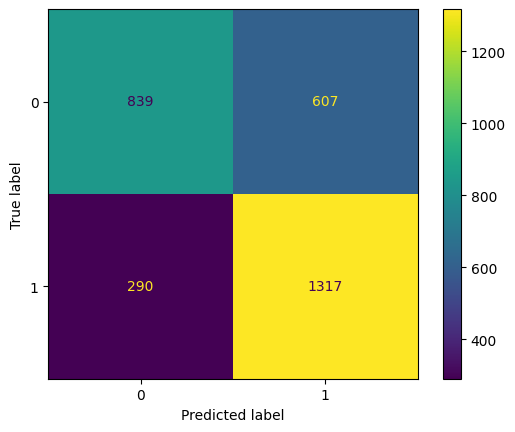

In [26]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(xgb1.best_estimator_, X_test, y_test)
plt.show()

- Recall of 81.9% show that this model correctly identifies most real positives.
- Reasonable F1-score (0.746) show a decent balance between precision & recall.
- However, the high false positive rate (607 cases) indicates that this model may incorrectly classify some negatives as positives.


**Feature Importance Comparison**

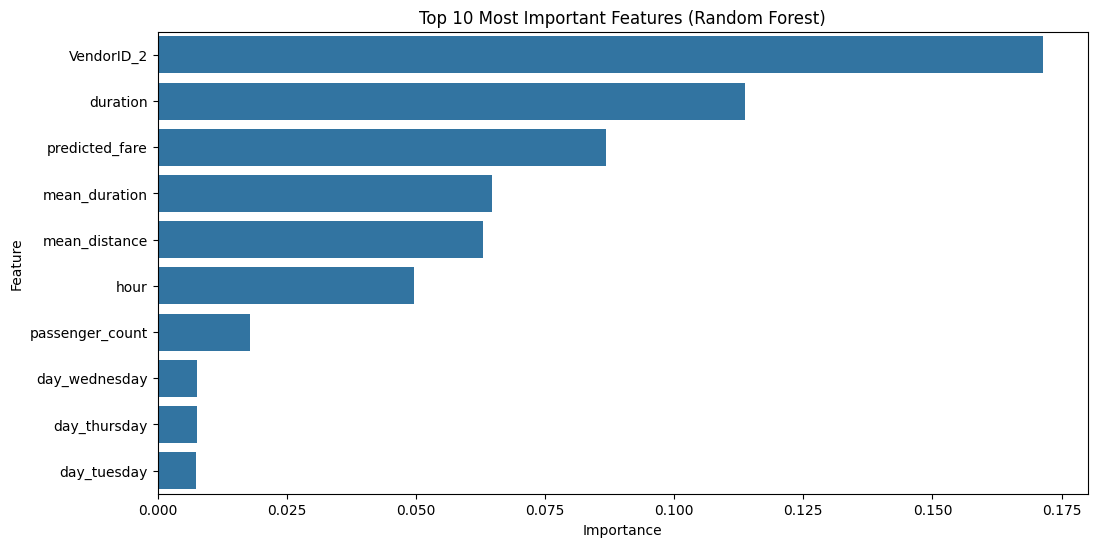

In [27]:

# Get feature importance values from the best Random Forest model
importances = rf1.best_estimator_.feature_importances_

# Get feature names from X_test
feature_names = X_test.columns

# Convert to DataFrame for better handling
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort features by importance (descending) and select the top 10
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)[:10]

# Plot using Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df)

# Customize plot
plt.title('Top 10 Most Important Features (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

- VendorID has the biggest influence on predictions. It might be strongly linked to the outcome.
- Besides, time-based features (Duration, Hour, Day of the Week) are significant.
- Distance & Fare are also important in this prediction model.

## **Future Exploration**
For further improvement, the following steps can be explored:

- Feature Engineering – Introduce additional derived features or interactions to enhance model performance.

- Threshold Tuning – Adjust classification thresholds to optimize for precision vs. recall trade-offs based on business needs.

- Deployment – Implement the trained model in a real-world application for real-time predictions.